## Project 2 - Supervised Learning - A mix of Classification and Regression Model via Gradient Descent
### Due: Nov/19/2021 Frinday 11:59 PM

### Project Description
In the data, there are four columns - $x$, $y$, $z$, and class where $z$ is the continous target and the class categorizes each $z$. Knowing that $z$ is a function 

For each class $k$, $z_k$ is a sum of multiple exponential functions as shown below: 

$$z_k(x,y)=-C\Big[\Big(\sum_{n,m=1}^4\exp\big[{-\big((x+C_{kn})^2+(y+C_{km})^2\big)\big]}\Big)+\exp\big[-(x+C_{k})^2)\big]+\exp{\big[-(y+C_{k})^2\Big]}\big]$$
where $C$, $C_k$, $C_{km}$, and $C_{kn}$ are unkonwn constant where $C$ is the same for all $k's$. 

The goal is to build a model that predidicts $z$, $M(H,Z)$, where $M(H,Z)$ is the combination of classifier $H(x,y)$ and regression $Z(z_k(x,y))$ where $z_k(x,y)$ is a submodel for each $k$: 
$$Z(x,y,k)=Z(z_1,z_2,\cdots,z_k)$$
The workflow can summarize as following:
1. classify $k$ using $H$ and identify the class $k^*$.
2. predict $z$ using indiviual $z_k\in Z$.

$$x,y,k\implies H(x,y) \implies \text{output:} k^* \implies Z(z_k(x,y,k)) \text{for each k} \implies \text{output:} z^*$$

### Model Implementation

#### Classifier $H(x,y)$: [30 pts]

Using `sklearn`, build a classifier $H(x,y)$ to classify `class` $k$. 
- use logistic regression and SVM.
- report the accuracy of each classifier and choose one for $H$ with explanaitons. 
- predict $k$ using $H$.  

#### Regressions $Z(x,y,k)$: [30 pts]
Using `sklearn`, build $k$ many models that predicts $z$ for each $k$ and determine the constants, $C$, $C_k$, $C_{km}$ and $C_{kn}$, for each $z_k$. 
- ues linear regression and Gaussain Process.
- report the constants and room mean squared error (RMSE) for each aglorithm for each $k$. 
$$\text{RMSE}=\Big(\sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-z_i^*)^2}\Big)$$ 
where $z_i^*$ is the predicted value of $z_i$

#### M(H,Z) Evaluation [10 pts]
Build a function that predicts z using the learn from $H$. 
- report the overall RMSE. 

#### Gradient Descent [30 pts]
Using `numpy` and `pandas`, implement the a gradient descent function to estimate the constants for each $z_k$ using MSE:

$$\text{Mean Square Error (MSE)} = \frac{1}{2}\sum_{i=1}^n(z_i-z_i^*)^2$$
- determine constants, $C$, $C_k$, $C_{km}$, and $C_{kn}$, for each $k$
- test which learning rate $\eta$ terminates faster when the acceptance error $\epsilon$ is $\epsilon\le0.005$ and the learning rate $\eta$ is $[10^{-2},10^{-3},10^{-4}$]. If the given $\eta$ is not sufficient, then test with different $\eta$. 
- present the true model $Z_k$.
- predict $z$ and report RMSE. Do for each $k$ and overall. 

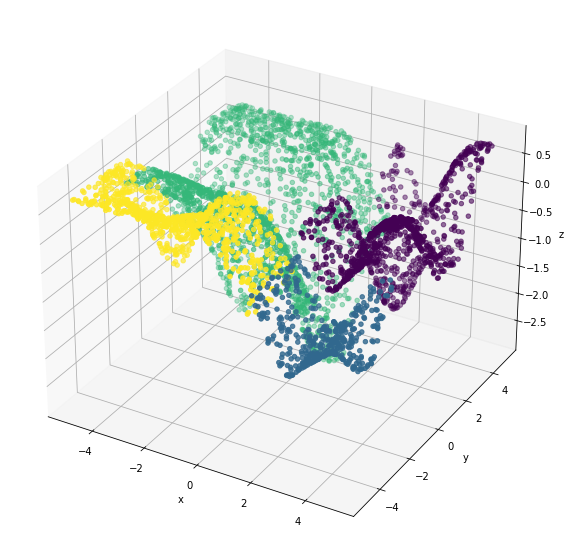

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
from sklearn.utils.optimize import _check_optimize_result
import seaborn as sns

df = pd.read_csv('F21_CS559_Project2.csv')
df = df.sort_values(['class','x','y','z'],ascending=True)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'],df['y'],df['z'],c=df['class'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

#### Classifier H(x,y) using Logistic regression


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report

X = df.drop(columns=['z','class'])
y = df['class']

LogRegclf = LogisticRegression()
LogRegclf.fit(X,y)
logRegy = LogRegclf.predict(X)
print('Logistic Regression accuracy:',accuracy_score(y,logRegy)*100)
print(classification_report(y,logRegy,target_names=['0','1','2','3']))


Logistic Regression accuracy: 99.625
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       990
           1       1.00      0.99      0.99       434
           2       1.00      1.00      1.00      1758
           3       1.00      0.99      1.00       818

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



#### Classifier H(x,y) using SVM

In [3]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

svmclf = SVC()
svmclf.fit(X,y)
svmy = svmclf.predict(X)
print('SVM accuracy:',accuracy_score(y,svmy)*100)
print(classification_report(y,svmy,target_names=['0','1','2','3']))



SVM accuracy: 99.275
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       990
           1       0.98      0.99      0.98       434
           2       1.00      1.00      1.00      1758
           3       1.00      0.98      0.99       818

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



In [4]:
# Model Selection
# We can see that Logistic regression performs better
# this could be due to fact that we have a very small number of features
# and a small sample size. Since the feature space is of a very low dimension
# and the points are scattered in a dense manner an optimal hyperplace creation without kernel
# trick is difficult. we could use svm with linear kernel for better performance

In [5]:
# get learn from H(x,y)
H = pd.DataFrame(df.drop(columns=['class']).values,columns=['x','y','z'])
H['class'] = logRegy
H = H.sort_values(['class','x','y','z'],ascending=True)

#### Regressions Z(x,y,k)

In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C,WhiteKernel
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

# function that trains and predicts z with GaussianProcessRgressor
def myGP(dataset):
    class_values = np.unique(dataset['class'])
    # kernel = C(1.0, (1e-3, 1e3)) * (RBF((1e-2, 1e2), (1e-2, 1e2)) + RBF((1e-2, 1e2)))
    kernel = (C(1.0, (1e-3, 1e3)) * RBF((1e-2, 1e2))) + WhiteKernel(1.0,(1e-3,1e3))
    z_pred = []
    rmse_list = []
    for cls in class_values:
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
        data = dataset.values[dataset['class'].values==cls]
        gp.fit(data[:,:2], data[:,2].reshape(-1,1))
        zk_pred, sigma = gp.predict(data[:,:2], return_std=True)
        z_pred=np.append(z_pred,zk_pred)
        rmsek = np.sqrt(np.square(np.subtract(data[:,2],zk_pred)).mean())
        rmse_list.append(rmsek)
    return z_pred,rmse_list
    
# function that trains and predicts z with LinearRegression
def myLinearRegression(dataset):
    class_values = np.unique(dataset['class'])
    z_pred = []
    rmse_list = []
    for cls in class_values:
        lr = LinearRegression()
        data = dataset.values[dataset['class'].values==cls]
        lr.fit(data[:,:2], data[:,2])
        zk_pred = lr.predict(data[:,:2])
        z_pred=np.append(z_pred,zk_pred)
        rmsek = np.sqrt(np.square(np.subtract(data[:,2],zk_pred)).mean())
        rmse_list.append(rmsek)
    return z_pred,rmse_list

        

In [37]:
# Get predictions on original data from created models (myGP and myLinearRegression)
z_pred_GP,rmsek_GP = myGP(df)
z_pred_LR,rmsek_LR = myLinearRegression(df)

In [38]:
# report RMSE for each k for each algorithm
rmsedf = pd.DataFrame([rmsek_GP,rmsek_LR],columns=['class 0','class 1','class 2','class 3'],index=['GaussianProcess RMSE','LinearRegression RMSE'])
rmsedf

,class 0,class 1,class 2,class 3
GaussianProcess RMSE,0.908331,0.534045,1.091976,0.477148
LinearRegression RMSE,0.573999,0.373186,0.667947,0.305203


In [9]:
# Define regression function Z(x,y,k)

# first line args (x,y,k), C and ck
# second line args ckn
# third line args ckm
def Zk(XYk,C,c1,c2,c3,c4,\
            c11,c12,c13,c14,c21,c22,c23,c24,c31,c32,c33,c34,c41,c42,c43,c44,\
            c1_1,c1_2,c1_3,c1_4,c2_1,c2_2,c2_3,c2_4,c3_1,c3_2,c3_3,c3_4,c4_1,c4_2,c4_3,c4_4):

    x1 = XYk.values[XYk['class'].values==0][:,0]
    y1 = XYk.values[XYk['class'].values==0][:,1]

    x2 = XYk.values[XYk['class'].values==1][:,0]
    y2 = XYk.values[XYk['class'].values==1][:,1]

    x3 = XYk.values[XYk['class'].values==2][:,0]
    y3 = XYk.values[XYk['class'].values==2][:,1]

    x4 = XYk.values[XYk['class'].values==3][:,0]
    y4 = XYk.values[XYk['class'].values==3][:,1]

    result1=-C*(np.exp(-((x1+c11)**2+(y1+c1_1)**2))+np.exp(-((x1+c11)**2+(y1+c1_2)**2))+np.exp(-((x1+c11)**2+(y1+c1_3)**2))+np.exp(-((x1+c11)**2+(y1+c1_4)**2))+\
                np.exp(-((x1+c12)**2+(y1+c1_1)**2))+np.exp(-((x1+c12)**2+(y1+c1_2)**2))+np.exp(-((x1+c12)**2+(y1+c1_3)**2))+np.exp(-((x1+c12)**2+(y1+c1_4)**2))+\
                np.exp(-((x1+c13)**2+(y1+c1_1)**2))+np.exp(-((x1+c13)**2+(y1+c1_2)**2))+np.exp(-((x1+c13)**2+(y1+c1_3)**2))+np.exp(-((x1+c13)**2+(y1+c1_4)**2))+\
                np.exp(-((x1+c14)**2+(y1+c1_1)**2))+np.exp(-((x1+c14)**2+(y1+c1_2)**2))+np.exp(-((x1+c14)**2+(y1+c1_3)**2))+np.exp(-((x1+c14)**2+(y1+c1_4)**2))+\
                np.exp(-((x1+c1)**2))+np.exp(-((y1+c1)**2)))

    result2=-C*(np.exp(-((x2+c21)**2+(y2+c2_1)**2))+np.exp(-((x2+c21)**2+(y2+c2_2)**2))+np.exp(-((x2+c21)**2+(y2+c2_3)**2))+np.exp(-((x2+c21)**2+(y2+c2_4)**2))+\
                np.exp(-((x2+c22)**2+(y2+c2_1)**2))+np.exp(-((x2+c22)**2+(y2+c2_2)**2))+np.exp(-((x2+c22)**2+(y2+c2_3)**2))+np.exp(-((x2+c22)**2+(y2+c2_4)**2))+\
                np.exp(-((x2+c23)**2+(y2+c2_1)**2))+np.exp(-((x2+c23)**2+(y2+c2_2)**2))+np.exp(-((x2+c23)**2+(y2+c2_3)**2))+np.exp(-((x2+c23)**2+(y2+c2_4)**2))+\
                np.exp(-((x2+c24)**2+(y2+c2_1)**2))+np.exp(-((x2+c24)**2+(y2+c2_2)**2))+np.exp(-((x2+c24)**2+(y2+c2_3)**2))+np.exp(-((x2+c24)**2+(y2+c2_4)**2))+\
                np.exp(-((x2+c2)**2))+np.exp(-((y2+c2)**2)))

    result3=-C*(np.exp(-((x3+c31)**2+(y3+c3_1)**2))+np.exp(-((x3+c31)**2+(y3+c3_2)**2))+np.exp(-((x3+c31)**2+(y3+c3_3)**2))+np.exp(-((x3+c31)**2+(y3+c3_4)**2))+\
                np.exp(-((x3+c32)**2+(y3+c3_1)**2))+np.exp(-((x3+c32)**2+(y3+c3_2)**2))+np.exp(-((x3+c32)**2+(y3+c3_3)**2))+np.exp(-((x3+c32)**2+(y3+c3_4)**2))+\
                np.exp(-((x3+c33)**2+(y3+c3_1)**2))+np.exp(-((x3+c33)**2+(y3+c3_2)**2))+np.exp(-((x3+c33)**2+(y3+c3_3)**2))+np.exp(-((x3+c33)**2+(y3+c3_4)**2))+\
                np.exp(-((x3+c34)**2+(y3+c3_1)**2))+np.exp(-((x3+c34)**2+(y3+c3_2)**2))+np.exp(-((x3+c34)**2+(y3+c3_3)**2))+np.exp(-((x3+c34)**2+(y3+c3_4)**2))+\
                np.exp(-((x3+c3)**2))+np.exp(-((y3+c3)**2)))
                            
    result4=-C*(np.exp(-((x4+c41)**2+(y4+c4_1)**2))+np.exp(-((x4+c41)**2+(y4+c4_2)**2))+np.exp(-((x4+c41)**2+(y4+c4_3)**2))+np.exp(-((x4+c41)**2+(y4+c4_4)**2))+\
                np.exp(-((x4+c42)**2+(y4+c4_1)**2))+np.exp(-((x4+c42)**2+(y4+c4_2)**2))+np.exp(-((x4+c42)**2+(y4+c4_3)**2))+np.exp(-((x4+c42)**2+(y4+c4_4)**2))+\
                np.exp(-((x4+c43)**2+(y4+c4_1)**2))+np.exp(-((x4+c43)**2+(y4+c4_2)**2))+np.exp(-((x4+c43)**2+(y4+c4_3)**2))+np.exp(-((x4+c43)**2+(y4+c4_4)**2))+\
                np.exp(-((x4+c44)**2+(y4+c4_1)**2))+np.exp(-((x4+c44)**2+(y4+c4_2)**2))+np.exp(-((x4+c44)**2+(y4+c4_3)**2))+np.exp(-((x4+c44)**2+(y4+c4_4)**2))+\
                np.exp(-((x4+c4)**2))+np.exp(-((y4+c4)**2)))
                            
    return np.append(np.append(result1,result2),np.append(result3,result4))

In [10]:
from scipy.optimize import curve_fit
import scipy

def printConstants(data,pred,model):
    # Use Curve fit to find optimized parameters
    inp,_pcov= curve_fit(Zk, data[['x','y','class']], pred)

    # print model
    print('Constants for the model ' + model + ' :')

    # print C
    print('C:',inp[0])

    # print Ck for class 0 - 3
    print('Ck for each class:',inp[1],inp[2],inp[3],inp[4])
    print('\n')

    # print Ckn for class 0 - 3
    print('Ckn for class 0:',inp[5],inp[6],inp[7],inp[8])
    print('Ckn for class 1:',inp[9],inp[10],inp[11],inp[12])
    print('Ckn for class 2:',inp[13],inp[14],inp[15],inp[16])
    print('Ckn for class 3:',inp[17],inp[18],inp[19],inp[20])
    print('\n')

    # print Ckm for class 0 - 3
    print('Ckm for class 0:',inp[21],inp[22],inp[23],inp[24])
    print('Ckm for class 1:',inp[25],inp[26],inp[27],inp[28])
    print('Ckm for class 2:',inp[29],inp[30],inp[31],inp[32])
    print('Ckm for class 3:',inp[33],inp[34],inp[35],inp[36])
    print('\n')

### Report Constants for Linear Regression and Gaussian Process

In [11]:

printConstants(df,z_pred_LR,'Linear Regression')


Constants for the model Linear Regression :
C: 0.5930829899268558
Ck for each class: -1.9518277515435667 -23.874737172796387 -0.2175127281506088 -21.818080661133216


Ckn for class 0: 29812.20826059789 -89457.60310456132 29812.208260597843 29812.20274981267
Ckn for class 1: 73.50891490897706 73.49865997890097 73.50891490897848 73.5089149089788
Ckn for class 2: -103.74885997178833 -66.86765461473351 109.8857887657247 64.74201008262185
Ckn for class 3: -286.34010707197575 -23.222925901765738 249.5329162421125 64.13411728276745


Ckm for class 0: -8.4105052986118 -8.470990762331567 -8.470990762331562 -8.470990762333322
Ckm for class 1: 163.4859819148757 163.45082193716928 163.45082193716922 163.4508219371692
Ckm for class 2: 164.32773361562488 150.09462106748848 84.58447430292188 -394.95867220286067
Ckm for class 3: -79.04186350353868 55.95972848014255 19.71737991701926 7.068146527898173




In [12]:
printConstants(df,z_pred_GP,'Gaussian Process')

Constants for the model Gaussian Process :
C: 0.696975085654293
Ck for each class: -2.520185398420592 37.288237712086506 -18.77014557882755 -2.5498560714071172


Ckn for class 0: 1400.0780844704527 -4184.47706741193 1400.0780844704464 1400.0779912834544
Ckn for class 1: 31.37377138697484 31.366777704087266 31.37377138697312 31.37377138697264
Ckn for class 2: -102.20934789449575 -144.4922035003636 25.252075845885972 225.4497472125209
Ckn for class 3: -700.5111420185373 -987.235326188494 996.4452895107494 695.6200220449559


Ckm for class 0: 12.389017704110628 12.415334075736155 12.415334075736158 12.415334075736155
Ckm for class 1: 23.84882331826054 23.849143502751904 23.849143502751907 23.8491435027519
Ckm for class 2: 150.9005631025233 102.45882299748072 60.864197704284784 -310.1012917958159
Ckm for class 3: -192.5703240286796 117.26221841101257 57.50984610043867 21.402677755699273




### M(H,Z) Evaluation

In [13]:
# predict z using the learn from H
def M(H):
    z,rmse  = myGP(H)
    overall_rmse = np.sqrt(np.square(np.subtract(H['z'].values,z)).mean())
    return z,overall_rmse

In [14]:
z_pred_M,overall_rmse = M(H)

In [15]:
print('overall RMSE :',overall_rmse)

overall RMSE : 2.6223802346560924e-06


### plot of predicted Z

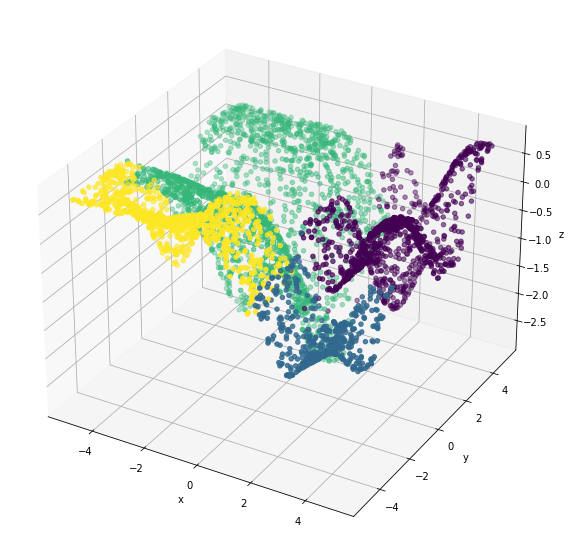

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(H['x'],H['y'],z_pred_M,c=H['class'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### Gradient Descent

![title](gradients.jpg)

In [17]:
def myGradient(H,z,alpha):
    # initialize weights
    c = 0.0
    ck = [0.0]*4
    ckn = [[0.0]*4 for _ in range(4)]
    ckm = [[0.0]*4 for _ in range(4)]

    # initiailize gradients
    dc = 0.0
    dck = [0.0]*4
    dckn = [[0.0]*4 for _ in range(4)]
    dckm = [[0.0]*4 for _ in range(4)]
    errors = []

    for i in range(0,10000):
        zargs = np.append(np.append(c,ck),np.append(ckn,ckm))
        error = np.subtract(z,Zk(H[['x','y','class']],*zargs))
        dc = np.mean(Zk(H[['x','y','class']],1,*zargs[1:]))
        for k in range(4):
            dat = H.values[H['class'].values==k]
            dck[k] = np.mean(-c*((2*(dat[:,0]+ck[k])*np.exp(-(dat[:,0]+ck[k])**2))+\
                             (2*(dat[:,1]+ck[k])*np.exp(-(dat[:,1]+ck[k])**2))))
            for n in range(4):
                dckn[k][n] = np.mean(-c*(2*(dat[:,0]+ckn[k][n])*np.exp(-(dat[:,0]+ckn[k][n])**2)*\
                   (np.exp(-(dat[:,1]+ckm[k][0])**2)+np.exp(-(dat[:,1]+ckm[k][1])**2)+\
                    np.exp(-(dat[:,1]+ckm[k][2])**2)+np.exp(-(dat[:,1]+ckm[k][3])**2))))
            
            for m in range(4):
                dckm[k][m] = np.mean(-c*(2*(dat[:,1]+ckm[k][m])*np.exp(-(dat[:,1]+ckn[k][m])**2)*\
                   (np.exp(-(dat[:,0]+ckn[k][0])**2)+np.exp(-(dat[:,0]+ckn[k][1])**2)+\
                    np.exp(-(dat[:,0]+ckn[k][2])**2)+np.exp(-(dat[:,0]+ckn[k][3])**2))))
        
        c = c - alpha*dc
        for k in range(4):
            ck[k]=ck[k]-alpha*dck[k]
            for n in range(4):
                ckn[k][n] = ckn[k][n]-alpha*dckn[k][n]
                ckm[k][n] = ckm[k][n]-alpha*dckm[k][n]
        errors.append(np.mean(error**2))
        if np.mean(error**2)<=0.005:
            break
    return c,ck,ckn,ckm,errors



In [18]:
# Test Leaning Rates
alphas = [1e-2,1e-3,1e-4]
times = []
errorlist=[]
for alpha in alphas:
    c,ck,ckn,ckm,errors = myGradient(H,z_pred_M,alpha)
    errorlist.append(errors)


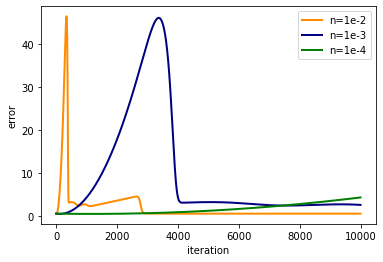

In [19]:
plt.figure()
plt.plot([x for x in range(len(errorlist[0]))], errorlist[0], color='darkorange', lw=2, label = 'n=1e-2')
plt.plot([x for x in range(len(errorlist[1]))], errorlist[1], color='navy', lw=2, label = 'n=1e-3')
plt.plot([x for x in range(len(errorlist[2]))], errorlist[2], color='green', lw=2, label = 'n=1e-4')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('error')
plt.show()

In [20]:
# we can see that n = 1e-2 terminates the fastest.

In [21]:
# Get Constants from the Gradient Descent implementation and alpha=0.01
gC,gCk,gCkn,gCkm,gerror = myGradient(H,z_pred_M,1e-2)

In [22]:
# Ckn and Ckm for the same class are all equal so printing only the first values.
print('C : ',gC)
print('Ck : ',gCk)
print('Ckn : ',gCkn[0][0],gCkn[1][0],gCkn[2][0],gCkn[3][0])
print('Ckm : ',gCkm[0][0],gCkm[1][0],gCkm[2][0],gCkm[3][0])

C :  7.213051630976811
Ck :  [4.289865094128689, 0.18179850618737994, -7.420093114170813, -3.89805423043742]
Ckn :  1.1924646739899354 0.1354165243491838 -0.23508085875545134 -0.00690749905693015
Ckm :  -0.2446812658383187 -0.646678981790367 1.2149781171142082e+158 -32.482360766613304


### test model function Zk using constants above

In [23]:
modelconstants = np.append(np.append(gC,gCk),np.append(gCkn,gCkm))
# get function return from Zk
z = Zk(df[['x','y','class']],*modelconstants)
df['zfunc'] = z
# get RMSEs
rmsek1 = np.sqrt(np.square(np.subtract(df.values[df['class'].values==0][:,4],df.values[df['class'].values==0][:,2])).mean())
rmsek2 = np.sqrt(np.square(np.subtract(df.values[df['class'].values==1][:,4],df.values[df['class'].values==1][:,2])).mean())
rmsek3 = np.sqrt(np.square(np.subtract(df.values[df['class'].values==2][:,4],df.values[df['class'].values==2][:,2])).mean())
rmsek4 = np.sqrt(np.square(np.subtract(df.values[df['class'].values==3][:,4],df.values[df['class'].values==3][:,2])).mean())
overallrm = np.sqrt(np.square(np.subtract(df['z'],z).mean()))

# Print RMSEs
print('RMSE for each K[0,1,2,3]: ',rmsek1,rmsek2,rmsek3,rmsek4)
print('Overall RMSE : ',overallrm)



RMSE for each K[0,1,2,3]:  0.7159116539924429 0.8898430396035633 0.8938284967409514 0.5343924927973096
Overall RMSE :  0.27233518743631224
